In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

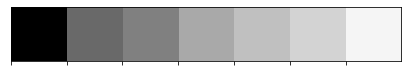

In [31]:
colors = ['darkolivegreen', 'olivedrab', 'yellowgreen', 'honeydew',
          'bisque', 'orange', 'darkorange']
colors = ['black', 'dimgray', 'gray', 'darkgray',
          'silver', 'lightgray', 'whitesmoke']

cmap = sns.color_palette(colors)
sns.palplot(cmap)

In [32]:
dataset = pd.read_csv('../../data/data-tarquinia-latest.csv',
                      sep='\t', decimal=',', index_col='id')
labels = dataset['PROVENIENZA']

In [33]:
def check_row(row):
    if (row < 0.5).all() and sum(row > 0) <= 2:
        return False
    if (row >= 0.5).all() and sum(row < 1) <= 2:
        return False
    return True
    

def get_heatmap_values(experiment, verbose=False):
    data = pd.read_csv(f'../../models/JAS/{experiment}/global_predictions.csv')
    data.set_index('id', inplace=True)
    data.insert(loc=0, column='Class', value=labels)

    for col in data.columns:
        if col[-6:-2] == 'best':
            if verbose:
                print(f'renaming {col} to {col[:-7]}')
            data.rename(columns={col: col[:-7]}, inplace=True)

    cols_to_be_dropped = [f'{experiment}-LDA',
                          f'{experiment}-MLP',
                          f'{experiment}-SVM-lin',
                          f'{experiment}-SVM-rbf',
                          f'{experiment}-SVM-poly',
                          f'{experiment}-DT',
                          f'{experiment}-RF',
                          f'{experiment}-KNN',
                          f'{experiment}-LR',
                          f'{experiment}-NB']

    for col in cols_to_be_dropped:
        del data[col]
    
    # sanity check
    for col in data.columns:
        if col.endswith('confidence'):
            try:
                assert set(data[col].unique()) <= {0.5, 0.75, 1}
            except AssertionError:
                print(col)
                print(data[col].unique())
    
    models = ['LDA', 'MLP', 'SVM-lin', 'SVM-rbf', 'SVM-poly', 'DT', 'RF', 'KNN',
          'LR', 'NB']

    for model in models:
        data[model] = (1 - data[f'{experiment}-{model}-majority']) * \
            (1 - data[f'{experiment}-{model}-confidence']) + \
            data[f'{experiment}-{model}-majority'] * \
            data[f'{experiment}-{model}-confidence']
        del data[f'{experiment}-{model}-confidence']
        del data[f'{experiment}-{model}-majority']

    #data.set_index('id', inplace=True)

    index = []
    values = []
    for i, row in data.iterrows():
        if check_row(row):
            index.append(i)
            values.append(row.values)
    
    discordant = pd.DataFrame(values, index=index, columns=['Class'] + models)
    #discordant.insert(loc=0, column='Class', value=labels)

    return discordant[['Class', 'NB', 'KNN', 'SVM-lin', 'SVM-poly',
           'SVM-rbf', 'RF', 'LDA', 'DT', 'LR', 'MLP']]

def get_heatmap(experiment):
    discordant = get_heatmap_values(experiment)
    plt.subplots(figsize=(10, 5))

    sns.heatmap(discordant, annot=False, cmap=cmap,
                vmin=0, vmax=1, cbar=False)
    plt.tick_params(axis='both', which='major',
                    labelsize=10, labelbottom = False,
                    bottom=False, top = False, labeltop=True)
    plt.tick_params(length=0)
    plt.show()

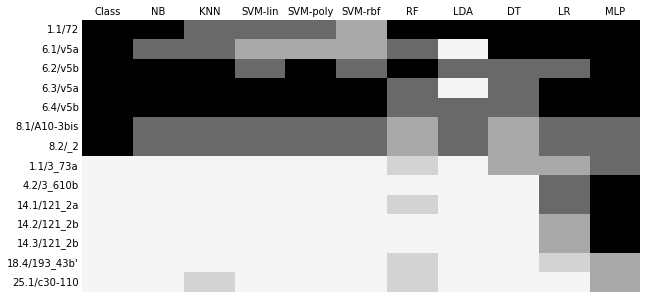

In [34]:
get_heatmap('all_measures')

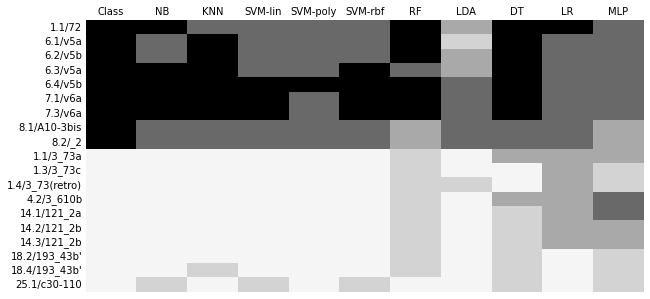

In [35]:
get_heatmap('frag_nosample')

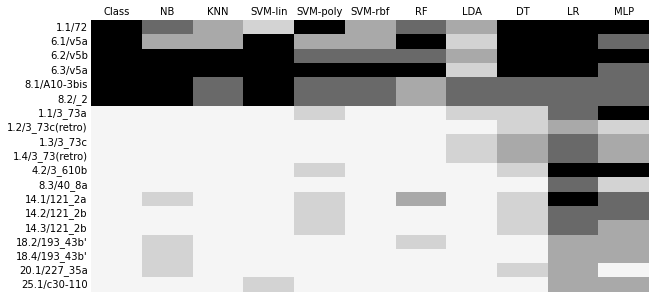

In [36]:
get_heatmap('frag_sample-2')